In [29]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\PYWORK\NHITS


In [30]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT, LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [31]:
cutoff_date = '2022-04-30' ## len = 65
test_period = 8  ## 예측 기간 (월)
corr_rate = 0.7 ## Lag corr rate
hist_corr_rate = 0.9 ## Lag corr rate
future_variable_limit = 2
hist_variable_limit = 5

## <원 data set>

In [32]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

df_tgt = df.iloc[:,3:]
scaler = StandardScaler()
scaler.fit(df_tgt)
arr = scaler.transform(df_tgt)
df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)
raw_y_set_resampled.rename(columns={'lioh_cif_fast_kg_spot_exchng':'y2'},inplace=True)
del raw_y_set_resampled['unique_id']

## Feature shift

In [33]:
%%time

raw_y_set_resampled = raw_y_set_resampled[raw_y_set_resampled.date<=cutoff_date]
raw_y_set_shifted_merged = raw_y_set_resampled['date']

for i in range(len(raw_y_set_resampled.columns)):
    if i == len(raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(test_period-1,test_period):
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)+ '_'))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

CPU times: total: 15.1 s
Wall time: 26.2 s


#### 해당 기간에서의 lag corr best

In [34]:
raw_y_set_shifted_merged

,date,y,y_8_,y2,y2_8_,Baltic Dry Index (BDI),Baltic Dry Index (BDI)_8_,Howe Robinson Container Index,Howe Robinson Container Index_8_,Shanghai Containerized Freight Index (SCFI),...,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_Open_8_,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_High_8_,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Low_8_,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Close_8_,Allkem Limited (AKE.AX)_price_Adj Close,Allkem Limited (AKE.AX)_price_Adj Close_8_
0,2016-01-31,20.177268,NaN,-0.237734,NaN,-1.302468,NaN,-0.644064,NaN,-0.195705,...,-0.915916,NaN,-0.911882,NaN,-0.921663,NaN,-0.909069,NaN,-0.909069,NaN
1,2016-02-29,23.306868,NaN,-0.054803,NaN,-1.396112,NaN,-0.645288,NaN,-0.182527,...,-0.910118,NaN,-0.915569,NaN,-0.908508,NaN,-0.916207,NaN,-0.916207,NaN
2,2016-03-31,25.223010,NaN,0.133909,NaN,-1.305967,NaN,-0.644523,NaN,-0.362815,...,-0.833402,NaN,-0.834459,NaN,-0.834589,NaN,-0.834453,NaN,-0.834453,NaN
3,2016-04-30,25.308243,NaN,0.173425,NaN,-1.041598,NaN,-0.648195,NaN,-0.472294,...,-0.691659,NaN,-0.695181,NaN,-0.693237,NaN,-0.700107,NaN,-0.700107,NaN
4,2016-05-31,24.875099,NaN,0.107095,NaN,-1.026945,NaN,-0.645747,NaN,-0.487834,...,-0.497700,NaN,-0.494779,NaN,-0.496022,NaN,-0.493870,NaN,-0.493870,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2021-12-31,33.043478,11.326087,0.286579,-0.652782,1.582281,1.161139,1.839908,0.215543,1.084157,...,1.185124,0.173441,1.187299,0.191123,1.189690,0.181815,1.197156,0.198840,1.197156,0.198840
72,2022-01-31,43.260870,12.727273,0.631414,-0.602008,0.318707,1.739329,1.983558,0.394838,1.463396,...,1.610945,0.343123,1.608097,0.341999,1.585530,0.337288,1.586450,0.341566,1.586450,0.341566
73,2022-02-28,56.425000,13.340909,1.270279,-0.544854,0.406105,1.700096,2.294724,0.652644,1.435042,...,1.168835,0.295629,1.174279,0.292393,1.163390,0.301950,1.167415,0.293123,1.167415,0.293123
74,2022-03-31,71.086957,14.045455,2.126927,-0.489898,1.148209,2.001985,2.612162,1.135170,1.241856,...,1.471655,0.519217,1.468981,0.524612,1.476677,0.536282,1.477051,0.534588,1.477051,0.534588


In [35]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y']
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y2']
raw_y_set_shifted_merged_filtered_y = raw_y_set_shifted_merged_filtered.iloc[:,:1]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_y[raw_y_set_shifted_merged_filtered_y.y >= corr_rate]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[raw_y_set_shifted_merged_filtered_upto_corr_rate.index.str.contains(f'_{test_period}_')]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[:future_variable_limit]

futr_list = raw_y_set_shifted_merged_filtered_upto_corr_rate.index.values.tolist()
futr_list = [word.replace(f"_{test_period}_", "") for word in futr_list]

# if 'li2co395_am_kg' in futr_list:
#     futr_list = [w.replace('li2co395_am_kg', 'li2co3_995_am_kg') for w in futr_list]
# raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)

# if 'y2' in futr_list:
#     (futr_list).remove('y2')
# if 'li2co395_am_kg' in futr_list:
#     (futr_list).remove('li2co395_am_kg')
# if 'li2co3_995_am_kg' in futr_list:
#     (futr_list).remove('li2co3_995_am_kg')
# if 'mn_mb_kg' in futr_list:
#     (futr_list).remove('mn_mb_kg')
# if 'al_lme_kg' in futr_list:
#     (futr_list).remove('al_lme_kg')

In [36]:
raw_y_set_shifted_merged_filtered_upto_corr_rate

,y
Howe Robinson Container Index_8_,0.868455
mn_mb_kg_8_,0.842373


In [37]:
futr_list

['Howe Robinson Container Index', 'mn_mb_kg']

#### 해당 기간에서의 corr best

In [38]:
hist_variable_limit

5

In [39]:
hist_var_chcek = raw_y_set_resampled.iloc[:,1:]

hist_var_corr = hist_var_chcek.corr()
hist_var_corr_filtered = hist_var_corr.loc[hist_var_corr.index != 'y']
hist_var_corr_filtered = hist_var_corr_filtered.loc[hist_var_corr_filtered.index != 'y2']
hist_var_corr_filtered_y = hist_var_corr_filtered.iloc[:,:1]
hist_var_corr_filtered_y_corr_rate = hist_var_corr_filtered_y[hist_var_corr_filtered_y.y >= hist_corr_rate]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_corr_rate[hist_var_corr_filtered_y_corr_rate.index.str.contains('li2co3')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only[hist_var_corr_filtered_y_only.index.str.contains('lioh')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only.sort_values('y',ascending=False)
hist_var_list = hist_var_corr_filtered_y_only.index.values.tolist()

hist_list = hist_var_list[:hist_variable_limit]
hist_list

['CPI_PRT_TOT_FOODENRG_AGRWTH',
 '대두 [미국(생산자 가격)] 현물',
 'CPI_BEL_TOT_AGRWTH',
 '중국 니켈 SEMIS 수입량',
 'CPI_PRT_TOT_AGRWTH']

In [40]:
hist_var_corr_filtered_y_only

,y
CPI_PRT_TOT_FOODENRG_AGRWTH,0.924210
대두 [미국(생산자 가격)] 현물,0.916158
CPI_BEL_TOT_AGRWTH,0.910310
중국 니켈 SEMIS 수입량,0.906632
CPI_PRT_TOT_AGRWTH,0.905268


#### static DF

In [41]:
static_df = pd.read_csv('/users/ESKO/PYWORK/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [42]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [43]:
# len(df.loc[df.ds<'2021-06-30'])

In [44]:
# len(Y_train_df)
# len(Y_test_df)
# len(df)

Test 용 DF 및 선행 변수 반영

In [45]:
Y_train_df = df[df.ds<=cutoff_date]
Y_test_df = df[df.ds>cutoff_date]

if len(Y_test_df) > 12:    
    Y_test_df = Y_test_df[:12]
else:
    pass
# Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]
# Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]

In [46]:
futr_list

['Howe Robinson Container Index', 'mn_mb_kg']

In [47]:
Y_test_df

,ds,unique_id,y,lioh_cif_fast_kg_spot_exchng,Baltic Dry Index (BDI),Howe Robinson Container Index,Shanghai Containerized Freight Index (SCFI),옥수수 For Grain [미국(생산자 가격)] 현물,원당 (daily) [ISA] 현물,대두 [미국(생산자 가격)] 현물,...,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close
76,2022-05-31,A,74.295455,2.621695,1.713126,2.501607,1.892086,2.385006,1.329234,3.305713,...,1.814178,1.807191,1.810962,1.808275,2.410643,2.106495,2.106820,2.111163,2.116623,2.116623
77,2022-06-30,A,73.000000,2.389233,1.060177,2.515599,2.230336,2.471976,1.161657,3.111422,...,1.310465,1.314768,1.273957,1.284862,2.410643,1.628496,1.623594,1.607981,1.608344,1.608344
78,2022-07-31,A,73.000000,2.389233,0.691597,2.439292,2.526593,2.377100,0.921668,2.852368,...,1.464141,1.460176,1.481963,1.473009,2.410643,1.436494,1.434052,1.439497,1.441548,1.441548
79,2022-08-31,A,73.000000,2.420773,-0.092744,2.119559,2.773368,2.369193,0.793818,2.593314,...,2.219001,2.233095,2.245839,2.264053,2.410643,2.144853,2.155770,2.181382,2.184215,2.184215
80,2022-09-30,A,74.047619,2.507937,-0.004062,1.188816,3.024986,2.250597,0.750690,1.621862,...,2.107414,2.092161,2.084336,2.084871,1.970948,2.828439,2.823884,2.834908,2.836251,2.836251
81,2022-10-31,A,77.673913,2.664680,0.381286,0.204375,3.036207,1.784119,0.691518,1.427572,...,2.352264,2.359441,2.354164,2.362142,2.222022,2.765597,2.782167,2.764528,2.761120,2.761120
82,2022-11-30,A,80.818182,2.828879,-0.226024,-0.008117,3.004479,1.784119,1.005474,1.621862,...,2.433279,2.443712,2.455263,2.452607,2.303940,2.830058,2.817705,2.816214,2.795982,2.795982
83,2022-12-31,A,80.882353,2.867154,-0.043847,-0.041773,3.301048,1.784119,1.131385,1.816153,...,1.980999,1.967237,1.981728,1.959693,1.857597,2.230517,2.206089,2.211335,2.207568,2.207568


In [59]:
future_date_series = pd.date_range(pd.date_range(cutoff_date,periods=2,freq='M')[1],periods=test_period,freq='M')
future_date = pd.DataFrame(future_date_series,columns=['ds'])
# future_date['unique_id'] = 'A'
future_df_temp = pd.concat([raw_y_set_resampled.rename(columns={'date':'ds'}).iloc[-(test_period+len(Y_test_df)):,:],future_date])
future_df_temp[futr_list] = future_df_temp[futr_list].shift(test_period)

future_df_with_index = list(['ds','unique_id']) + futr_list
future_df_with_index

future_df_temp = future_df_temp[future_df_temp.columns[future_df_temp.columns.isin(future_df_with_index)]].reset_index(drop=True)
future_df_temp.insert(1, 'unique_id', 'A')
futr_df = future_df_temp.iloc[-test_period:,:].reset_index(drop=True)
futr_df

,ds,unique_id,Howe Robinson Container Index,mn_mb_kg
0,2022-05-31,A,1.991462,1.860639
1,2022-06-30,A,1.998856,3.173886
2,2022-07-31,A,1.794166,3.457132
3,2022-08-31,A,1.839908,3.169070
4,2022-09-30,A,1.983558,3.029873
5,2022-10-31,A,2.294724,2.900262
6,2022-11-30,A,2.612162,1.549461
7,2022-12-31,A,2.556884,0.363279


In [61]:
aaa = pd.concat([Y_test_df,futr_df])

In [72]:
aaa = aaa.iloc[-8:,:]

#### No 변수

In [49]:
# horizon = len(Y_test_df)

# models = [
#           # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
#           # NBEATSx(h=12, input_size=24,
#           #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #       gpus=1,
#           #       scaler_type='robust',
#           #       stat_exog_list = None,  
#           #       futr_exog_list = futr_list,
#           #       max_steps=100,
#           #       # val_check_steps=10,
#           #       # early_stop_patience_steps=2
#           #      ),
#           NHITS(input_size=5 * horizon, 
#                 h=horizon+1,
#                 gpus = 1,
#                 stat_exog_list = None,
#                 hist_exog_list=None,
#                 futr_exog_list = None,
#                 # futr_exog_list = futr_list,
#                 # n_freq_downsample=[24, 12, 1],
#                 # mlp_units = [[512, 512], [512, 512], [512, 512]],
#                 # n_pool_kernel_size = [2, 2, 1],
#                 # n_freq_downsample=[24, 12, 1],
#                 scaler_type = 'standard',
#                 learning_rate=1e-4,
#                 pooling_mode = 'MaxPool1d',
#                 activation='ReLU',
#                 batch_size=128,
#                 random_seed=42,
#                 max_epochs=200
#                ),
#            # NHITS(
#            #       h,
#            #       input_size,
#            #       futr_exog_list=None,
#            #       hist_exog_list=None,
#            #       stat_exog_list=None,
#            #       stack_types: list = ['identity', 'identity', 'identity'],
#            #       n_blocks: list = [1, 1, 1],
#            #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
#            #       n_pool_kernel_size: list = [2, 2, 1],
#            #       n_freq_downsample: list = [4, 2, 1],
#            #       pooling_mode: str = 'MaxPool1d',
#            #       interpolation_mode: str = 'linear',
#            #       dropout_prob_theta=0.0,
#            #       activation='ReLU',
#            #       loss=MAE(),
#            #       learning_rate=0.001,
#            #       batch_size=32,
#            #       windows_batch_size: int = 1024,
#            #       step_size: int = 1,
#            #       scaler_type='identity',
#            #       random_seed=1,
#            #       num_workers_loader=0,
#            #       drop_last_loader=False,
#            #       **trainer_kwargs,
    
#           # TFT(h=12, 
#           #     input_size=5 * horizon,
#           #     # hidden_size=20,
#           #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
#           #     learning_rate=0.005,
#           #     stat_exog_list = None,
#           #     futr_exog_list = futr_list,
#           #     max_steps=100,
#           #     gpus=1,
#           #     # val_check_steps=10,
#           #     # early_stop_patience_steps=10,
#           #     scaler_type='robust',
#           #     # windows_batch_size=None,
#           #     enable_progress_bar=True),
#              ]
# nforecast_nv = NeuralForecast(models=models, freq='M')
# nforecast_nv.fit(df=Y_train_df)
# Y_hat_df_nv = nforecast_nv.predict(futr_df=futr_df).reset_index()

In [50]:
# # Plot predictions
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# Y_hat_df_nv = Y_test_df.merge(Y_hat_df_nv, how='left', on=['unique_id', 'ds'])
# plot_df_nv = pd.concat([Y_train_df, Y_hat_df_nv]).set_index('ds')

# plot_df_nv[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
# plt.axvline(cutoff_date, color='red')

# ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
# ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
# ax.set_xlabel('Date', fontsize=20)
# ax.legend(prop={'size': 15})
# ax.grid()

# fig.savefig(f'./data/forecast_plot_{cutoff_date}_nv.png')

In [51]:
# plot_df_nv[['y', 'NHITS']].to_csv(f'./data/forecasting_{cutoff_date}_nv.csv',index=False)

#### Yes 변수

In [75]:
Y_hat_df

,ds,unique_id,y,lioh_cif_fast_kg_spot_exchng,Baltic Dry Index (BDI),Howe Robinson Container Index,Shanghai Containerized Freight Index (SCFI),옥수수 For Grain [미국(생산자 가격)] 현물,원당 (daily) [ISA] 현물,대두 [미국(생산자 가격)] 현물,...,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close,NHITS
0,2022-05-31,A,74.295455,2.621695,1.713126,2.501607,1.892086,2.385006,1.329234,3.305713,...,1.807191,1.810962,1.808275,2.410643,2.106495,2.106820,2.111163,2.116623,2.116623,NaN
1,2022-06-30,A,73.000000,2.389233,1.060177,2.515599,2.230336,2.471976,1.161657,3.111422,...,1.314768,1.273957,1.284862,2.410643,1.628496,1.623594,1.607981,1.608344,1.608344,NaN
2,2022-07-31,A,73.000000,2.389233,0.691597,2.439292,2.526593,2.377100,0.921668,2.852368,...,1.460176,1.481963,1.473009,2.410643,1.436494,1.434052,1.439497,1.441548,1.441548,NaN
3,2022-08-31,A,73.000000,2.420773,-0.092744,2.119559,2.773368,2.369193,0.793818,2.593314,...,2.233095,2.245839,2.264053,2.410643,2.144853,2.155770,2.181382,2.184215,2.184215,NaN
4,2022-09-30,A,74.047619,2.507937,-0.004062,1.188816,3.024986,2.250597,0.750690,1.621862,...,2.092161,2.084336,2.084871,1.970948,2.828439,2.823884,2.834908,2.836251,2.836251,NaN
5,2022-10-31,A,77.673913,2.664680,0.381286,0.204375,3.036207,1.784119,0.691518,1.427572,...,2.359441,2.354164,2.362142,2.222022,2.765597,2.782167,2.764528,2.761120,2.761120,NaN
6,2022-11-30,A,80.818182,2.828879,-0.226024,-0.008117,3.004479,1.784119,1.005474,1.621862,...,2.443712,2.455263,2.452607,2.303940,2.830058,2.817705,2.816214,2.795982,2.795982,NaN
7,2022-12-31,A,80.882353,2.867154,-0.043847,-0.041773,3.301048,1.784119,1.131385,1.816153,...,1.967237,1.981728,1.959693,1.857597,2.230517,2.206089,2.211335,2.207568,2.207568,NaN


In [73]:
if len(Y_test_df) > 0:
    horizon = len(Y_test_df)
else:
    horizon = len(futr_df)
    
    
if cutoff_date <= '2021-12-31':
    flexible = None
else:
    flexible = futr_list

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          # NBEATSx(h=horizon, input_size=5 * horizon,
          #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #       gpus=1,
          #       scaler_type='robust',
          #       stat_exog_list = None,
          #       # hist_exog_list = hist_list,
          #       # futr_exog_list = None,  
          #       futr_exog_list = flexible,
          #       learning_rate=1e-4,
          #       mlp_units = [[512, 512], [512, 512], [512, 512]],
          #       batch_size=128,
          #       random_seed=42,
          #       n_blocks=[1, 1, 1],
          #       # val_check_steps=10,
          #       # early_stop_patience_steps=2
          #       max_steps=30
          #      ),
          NHITS(input_size=5 * horizon, 
                h=horizon,
                gpus = 1,
                stat_exog_list = None,
                # hist_exog_list = hist_list,
                # futr_exog_list = flexible,
                futr_exog_list = flexible,
                # n_blocks = [1, 1, 1],
                mlp_units = [[512, 512], [512, 512], [512, 512]],
                n_pool_kernel_size = [2, 2, 1],
                # n_freq_downsample=[24, 12, 1],
                scaler_type = 'standard',
                learning_rate=1e-4,
                pooling_mode = 'MaxPool1d',
                activation='ReLU',
                batch_size=128,
                random_seed=42,
                max_epochs=30
               ),
          # LSTM(h=horizon, input_size=5 * horizon,
          #        # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #        scaler_type='standard',
          #        learning_rate=1e-4,
          #        encoder_n_layers=2,
          #        encoder_hidden_size=128,
          #        context_size=10,
          #        decoder_hidden_size=128,
          #        decoder_layers=2,
          #        gpus = 1,
          #        futr_exog_list=flexible,
          #        hist_exog_list=None,
          #        stat_exog_list=None,
          #        max_steps=200
          #        ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=horizon, 
          #     input_size=5 * horizon,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     hidden_size=128,
          #     # n_head=4, 
          #     attn_dropout=0.2,
          #     # hist_exog_list=hist_list,
          #     dropout=0.6,
          #     learning_rate=1e-4,
          #     stat_exog_list = None,
          #     futr_exog_list = flexible,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     # enable_progress_bar=True,
          #     max_steps=200
          #    ),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
Y_hat_df = nforecast.predict(futr_df=aaa,static_df=static_df).reset_index()

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

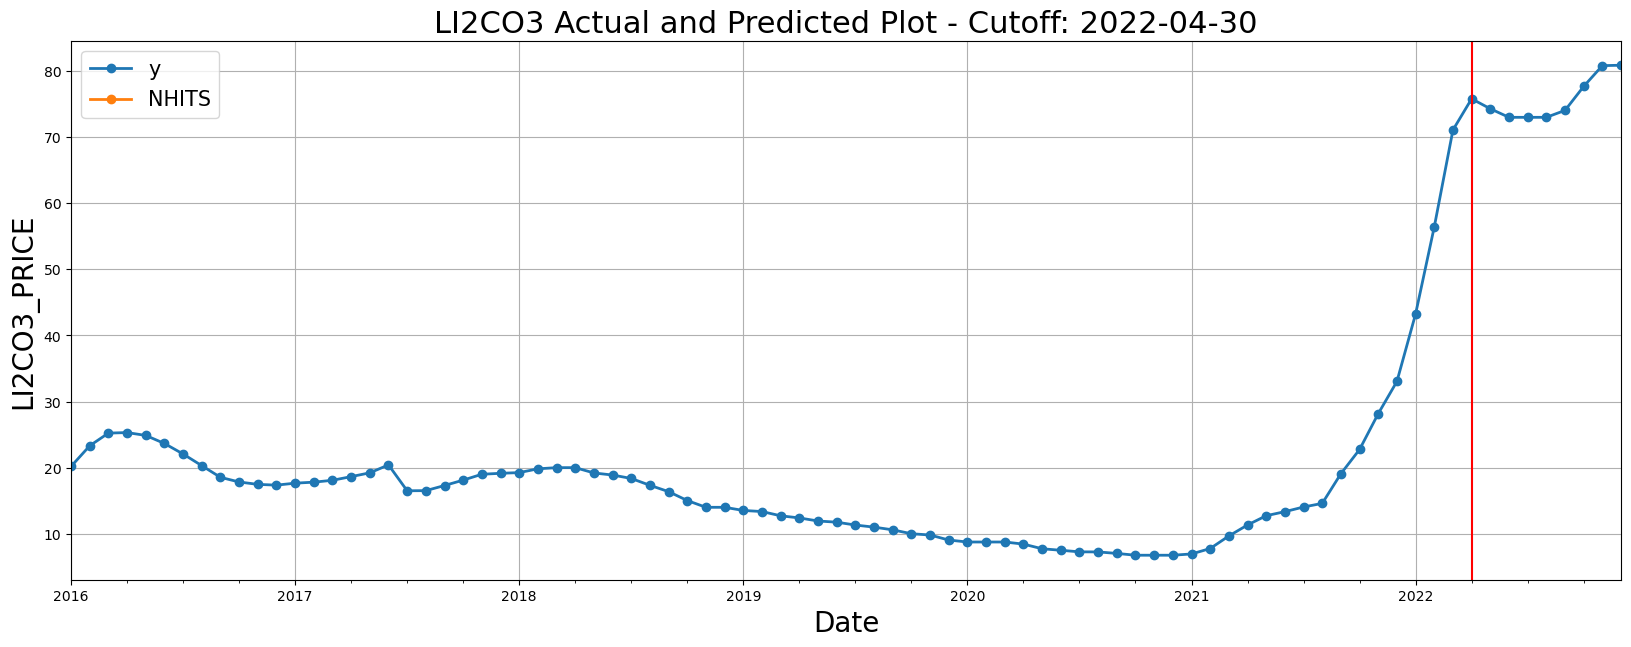

In [74]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y','NHITS']].plot(ax=ax, linewidth=2, marker='o')

plt.axvline(cutoff_date, color='red')
ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# fig1.savefig(f'./data/forecasting_{cutoff_date}.png', dpi=100)
fig.savefig(f'./data/forecast_plot_{cutoff_date}_wv.png')

In [55]:
plot_df[['y', 'NHITS']].to_csv(f'./data/forecast_plot_{cutoff_date}_wv.csv',index=False)

In [56]:
Y_train_df

,ds,unique_id,y,lioh_cif_fast_kg_spot_exchng,Baltic Dry Index (BDI),Howe Robinson Container Index,Shanghai Containerized Freight Index (SCFI),옥수수 For Grain [미국(생산자 가격)] 현물,원당 (daily) [ISA] 현물,대두 [미국(생산자 가격)] 현물,...,Pilbara Mineral Limited_price_Open,Pilbara Mineral Limited_price_High,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close
0,2016-01-31,A,20.177268,-0.237734,-1.302468,-0.644064,-0.195705,-0.461301,-0.468886,0.391356,...,-0.831670,-0.828692,-0.830830,-0.827825,-0.397665,-0.915916,-0.911882,-0.921663,-0.909069,-0.909069
1,2016-02-29,A,23.306868,-0.054803,-1.396112,-0.645288,-0.182527,-0.532459,-0.733272,0.138779,...,-0.748690,-0.746808,-0.752678,-0.750469,-0.397665,-0.910118,-0.915569,-0.908508,-0.916207,-0.916207
2,2016-03-31,A,25.223010,0.133909,-1.305967,-0.644523,-0.362815,-0.532459,-0.012903,0.099921,...,-0.731866,-0.730402,-0.733675,-0.731680,-0.397665,-0.833402,-0.834459,-0.834589,-0.834453,-0.834453
3,2016-04-30,A,25.308243,0.173425,-1.041598,-0.648195,-0.472294,-0.524553,-0.083130,-0.003701,...,-0.520540,-0.501075,-0.525438,-0.509230,-0.397665,-0.691659,-0.695181,-0.693237,-0.700107,-0.700107
4,2016-05-31,A,24.875099,0.107095,-1.026945,-0.645747,-0.487834,-0.445488,0.514051,-0.074941,...,-0.375846,-0.367456,-0.391346,-0.377609,-0.397665,-0.497700,-0.494779,-0.496022,-0.493870,-0.493870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2021-12-31,A,33.043478,0.286579,1.582281,1.839908,1.084157,0.969759,1.115623,0.520883,...,1.766336,1.775690,1.776023,1.790538,1.704423,1.185124,1.187299,1.189690,1.197156,1.197156
72,2022-01-31,A,43.260870,0.631414,0.318707,1.983558,1.463396,1.048823,0.916574,0.779937,...,2.677508,2.680955,2.665481,2.680401,2.510212,1.610945,1.608097,1.585530,1.586450,1.586450
73,2022-02-28,A,56.425000,1.270279,0.406105,2.294724,1.435042,1.467862,0.798730,1.945680,...,2.197789,2.207543,2.190755,2.181831,2.058747,1.168835,1.174279,1.163390,1.167415,1.167415
74,2022-03-31,A,71.086957,2.126927,1.148209,2.612162,1.241856,1.831557,1.195636,2.269497,...,2.026895,2.013125,2.037362,2.013198,1.906047,1.471655,1.468981,1.476677,1.477051,1.477051
